# A tutorial for using Tools21cm to create mock 21-cm radio measurement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tools21cm as t2c

In [2]:
from tqdm import tqdm
from glob import glob
from time import time

## Simulate cosmic reionization
We will use the interface to the [21cmfast](https://21cmfast.readthedocs.io/en/latest/) code to create simulations of the 21-cm signal during the peoch of reionization.

### Initial conditions
To begin modelling of cosmic structure formation, we initialise a gaussian random field (GRF) for matte in comoving coordinates. This field is normalised to match the linear matter power spectrum, which can be modelled with fitting functions (e.g. [Eisenstein & Hu 1998](https://arxiv.org/abs/astro-ph/9709112)) or using a Boltzmann solver (e.g. [CLASS](https://github.com/lesgourg/class_public) and [CAMB](https://camb.readthedocs.io/en/latest/)). In 21cmfast, the Eisenstein & Hu (1998) fit is implemented for LCDM.

In [3]:
HII_DIM = 128
BOX_LEN = 256

ic = t2c.run_21cmfast_init(                    
    user_params={"HII_DIM":HII_DIM, "DIM":HII_DIM*3, "BOX_LEN":BOX_LEN, "USE_INTERPOLATION_TABLES": True},
    cosmo_params={"OMb":0.049, "OMm":0.31, "POWER_INDEX":0.96, "SIGMA_8":0.83, "hlittle":0.67},
    write=False,
    )

print(f'This object contains the following fields:\n {ic.fields}')

Creating initial conditions...
...done
This object contains the following fields:
 {'lowres_density': <_cffi_backend.CField object at 0x155e98ab0>, 'lowres_vx': <_cffi_backend.CField object at 0x155e98d80>, 'lowres_vy': <_cffi_backend.CField object at 0x155e988d0>, 'lowres_vz': <_cffi_backend.CField object at 0x155e98bd0>, 'lowres_vx_2LPT': <_cffi_backend.CField object at 0x155e98b10>, 'lowres_vy_2LPT': <_cffi_backend.CField object at 0x155e98780>, 'lowres_vz_2LPT': <_cffi_backend.CField object at 0x155e984b0>, 'hires_density': <_cffi_backend.CField object at 0x155e98390>, 'hires_vx': <_cffi_backend.CField object at 0x155e98b70>, 'hires_vy': <_cffi_backend.CField object at 0x155e98a80>, 'hires_vz': <_cffi_backend.CField object at 0x155e98a50>, 'hires_vx_2LPT': <_cffi_backend.CField object at 0x155e98240>, 'hires_vy_2LPT': <_cffi_backend.CField object at 0x155e98630>, 'hires_vz_2LPT': <_cffi_backend.CField object at 0x155e989c0>, 'lowres_vcb': <_cffi_backend.CField object at 0x155e98990

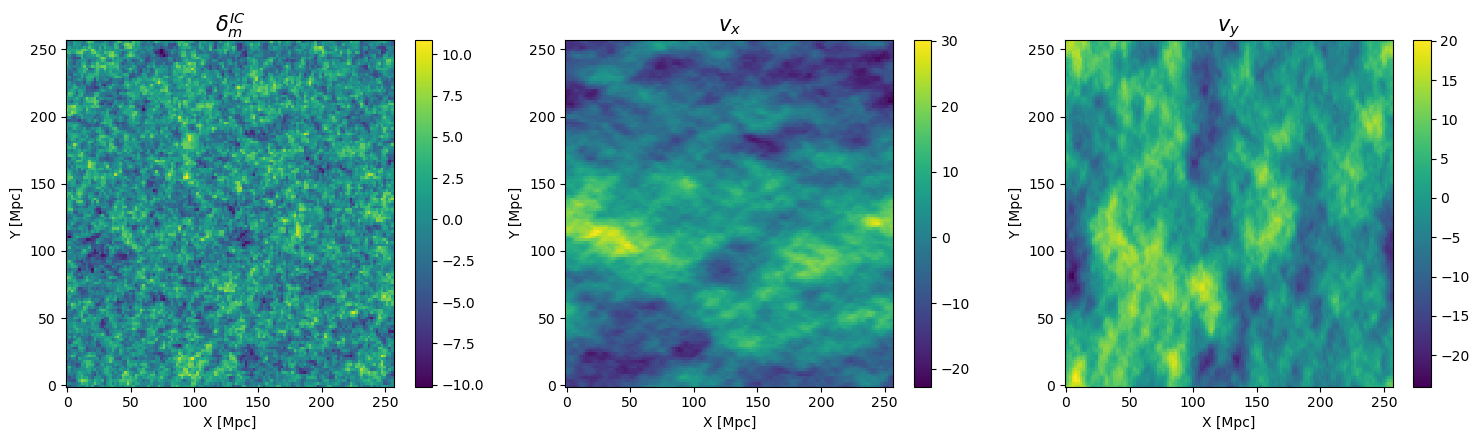

In [4]:
fig, axs = plt.subplots(1,3,figsize=(15,4.5))

axs[0].set_title('$\delta^{IC}_m$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_density.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_density.shape[2])
c0 = axs[0].pcolor(xx, yy, ic.lowres_density[:,:,10])
fig.colorbar(c0, ax=axs[0], orientation='vertical') 

axs[1].set_title('$v_x$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_vx.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_vx.shape[2])
c1 = axs[1].pcolor(xx, yy, ic.lowres_vx[:,:,10])
fig.colorbar(c1, ax=axs[1], orientation='vertical') 

axs[2].set_title('$v_y$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_vy.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_vy.shape[2])
c2 = axs[2].pcolor(xx, yy, ic.lowres_vy[:,:,10])
fig.colorbar(c2, ax=axs[2], orientation='vertical') 

for ax in axs:
    ax.set_xlabel('X [Mpc]')
    ax.set_ylabel('Y [Mpc]')

plt.tight_layout()
plt.show()

### Matter distribution

Note that, in case of more accurate frameworks (e.g. N-body simulation), this field is not called the initial conditions. For these frameworks, this GRF is perturbed using Lagrangian perturbation theory (LPT) at a very high redshift. 21cmfast is a semi-numerical code and, therefore, LPT corrected matter field used as the matter fields at different redshifts.

In [5]:
redshifts = [7.0,9.0,11.0]

In [6]:
dens = t2c.run_21cmfast_matter(
        redshifts,
        init_box=ic,
        write=False,
        )

print(f'This output contains: \n {dens.keys()}')

Creating matter distribution...
...done
This output contains: 
 dict_keys([7.0, 9.0, 11.0])


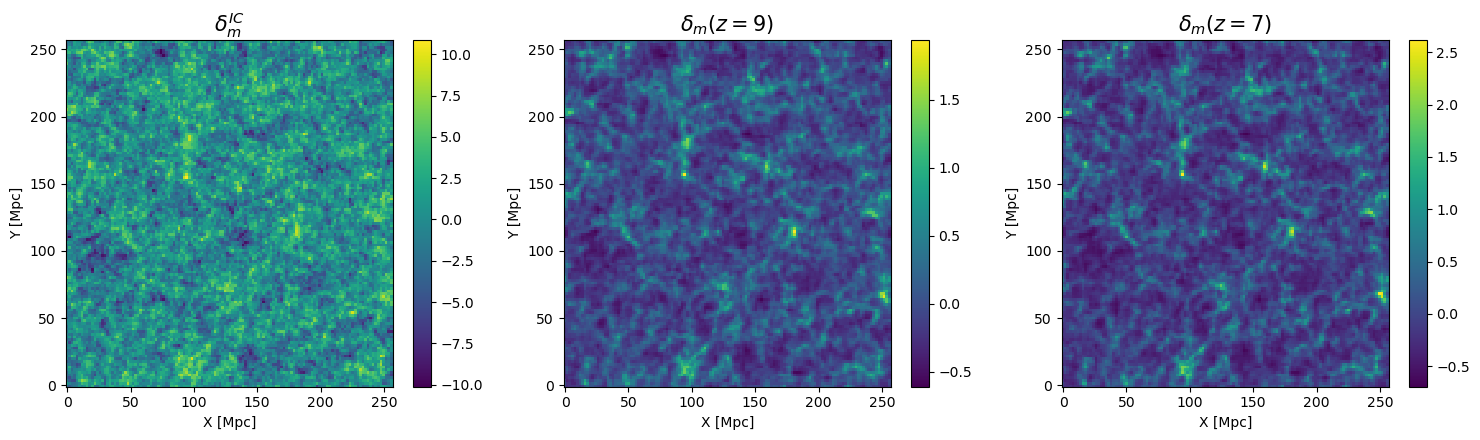

In [7]:
fig, axs = plt.subplots(1,3,figsize=(15,4.5))

axs[0].set_title('$\delta^{IC}_m$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_density.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_density.shape[2])
c0 = axs[0].pcolor(xx, yy, ic.lowres_density[:,:,10])
fig.colorbar(c0, ax=axs[0], orientation='vertical')

axs[1].set_title('$\delta_m(z=9)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, dens[9.0].density.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, dens[9.0].density.shape[2])
c1 = axs[1].pcolor(xx, yy, dens[9.0].density[:,:,10])
fig.colorbar(c1, ax=axs[1], orientation='vertical')

axs[2].set_title('$\delta_m(z=7)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, dens[7.0].density.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, dens[7.0].density.shape[2])
c2 = axs[2].pcolor(xx, yy, dens[7.0].density[:,:,10])
fig.colorbar(c2, ax=axs[2], orientation='vertical')

for ax in axs:
    ax.set_xlabel('X [Mpc]')
    ax.set_ylabel('Y [Mpc]')

plt.tight_layout()
plt.show()


### Model intergalactic medium reionization
21cmfast models the ionising sources to reside in the dark matter haloes that is simulated from the matter field using the extended Press-Schechter formalism. Reionization is modelled based on the semi-numerical formalism developed in [Furlanetto et al. (2004)](https://arxiv.org/abs/astro-ph/0403697). The properties of the light sources are defined with the `astro_params` parameter below.

In [8]:
coevals = t2c.run_21cmfast_coeval(
        redshifts,
        init_box=ic,
        astro_params={"F_STAR10":np.log10(0.05), "ALPHA_STAR":0.5, "F_ESC10":np.log10(0.1), "ALPHA_ESC":-0.5, "t_STAR":0.5, "M_TURN":8.7, "R_BUBBLE_MAX":15, "L_X":40},
        flag_options={"USE_HALO_FIELD":False, "USE_MASS_DEPENDENT_ZETA":True, "INHOMO_RECO":False, "PHOTON_CONS":False},
        write=False,
        )

print(f'This output contains: \n {coevals.keys()}')

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Modelling reionization...


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


...done
This output contains: 
 dict_keys([7.0, 9.0, 11.0])


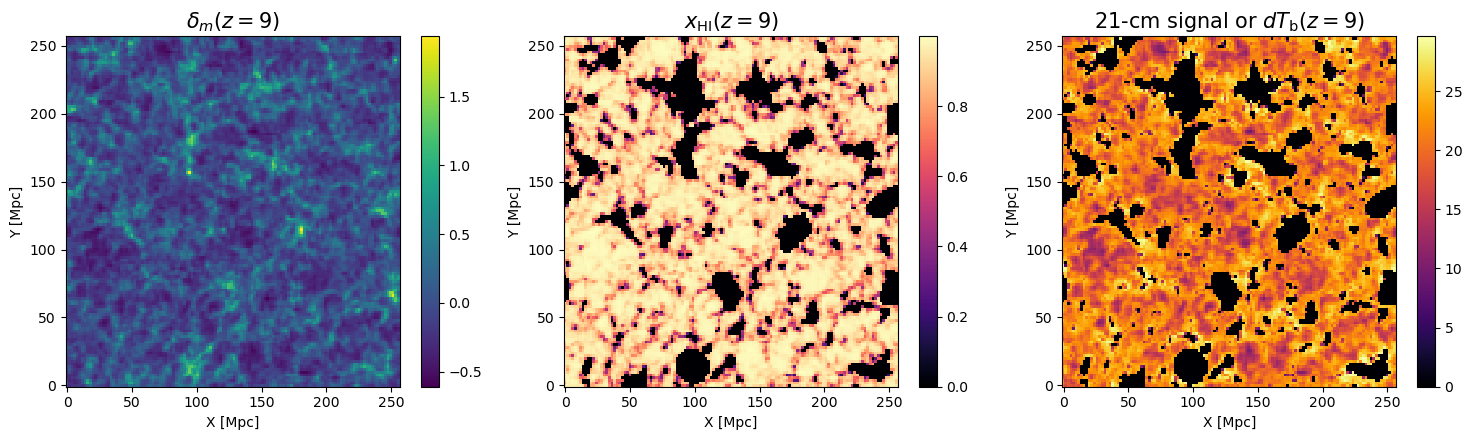

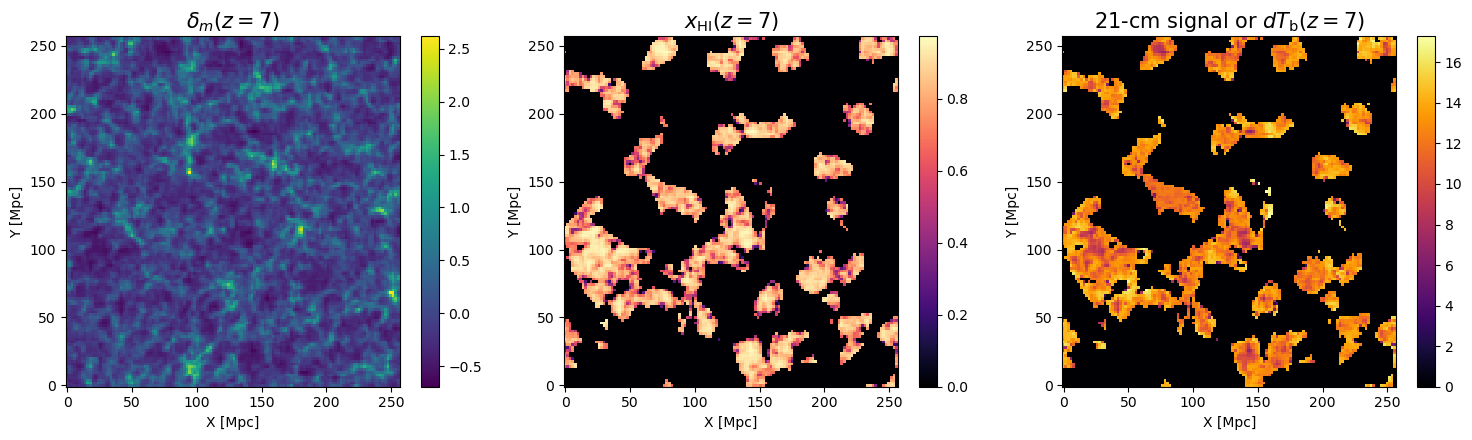

In [9]:
fig, axs = plt.subplots(1,3,figsize=(15,4.5))

axs[0].set_title('$\delta_m(z=9)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, dens[9.0].density.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, dens[9.0].density.shape[2])
c0 = axs[0].pcolor(xx, yy, dens[9.0].density[:,:,10])
fig.colorbar(c0, ax=axs[0], orientation='vertical')

axs[1].set_title(r'$x_\mathrm{HI}(z=9)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, coevals[9.0].xH_box.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, coevals[9.0].xH_box.shape[2])
c1 = axs[1].pcolor(xx, yy, coevals[9.0].xH_box[:,:,10], cmap='magma')
fig.colorbar(c1, ax=axs[1], orientation='vertical')

axs[2].set_title(r'21-cm signal or $dT_\mathrm{b}(z=9)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, coevals[9.0].brightness_temp.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, coevals[9.0].brightness_temp.shape[2])
c2 = axs[2].pcolor(xx, yy, coevals[9.0].brightness_temp[:,:,10], cmap='inferno')
fig.colorbar(c2, ax=axs[2], orientation='vertical')

for ax in axs:
    ax.set_xlabel('X [Mpc]')
    ax.set_ylabel('Y [Mpc]')

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1,3,figsize=(15,4.5))

axs[0].set_title('$\delta_m(z=7)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, dens[7.0].density.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, dens[7.0].density.shape[2])
c0 = axs[0].pcolor(xx, yy, dens[7.0].density[:,:,10])
fig.colorbar(c0, ax=axs[0], orientation='vertical')

axs[1].set_title(r'$x_\mathrm{HI}(z=7)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, coevals[7.0].xH_box.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, coevals[7.0].xH_box.shape[2])
c1 = axs[1].pcolor(xx, yy, coevals[7.0].xH_box[:,:,10], cmap='magma')
fig.colorbar(c1, ax=axs[1], orientation='vertical')

axs[2].set_title(r'21-cm signal or $dT_\mathrm{b}(z=7)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, coevals[7.0].brightness_temp.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, coevals[7.0].brightness_temp.shape[2])
c2 = axs[2].pcolor(xx, yy, coevals[7.0].brightness_temp[:,:,10], cmap='inferno')
fig.colorbar(c2, ax=axs[2], orientation='vertical')

for ax in axs:
    ax.set_xlabel('X [Mpc]')
    ax.set_ylabel('Y [Mpc]')

plt.tight_layout()
plt.show()


### Light-cones

The 21-cm signal will be observed as a function of field of view and frequency, which is known as a 21-cm light-cone. Therefore, we will not get cubes at every redshift as the simulations provide us. We can construct such light-cone with Tools21cm.

We first simulate the 21-cm signal at different redshifts.

In [10]:
file_redshifts = np.arange(5.4,12,0.10)
coevals_full   =  t2c.run_21cmfast_coeval(
        file_redshifts,
        init_box=ic,
        astro_params={"F_STAR10":np.log10(0.05), "ALPHA_STAR":0.5, "F_ESC10":np.log10(0.1), "ALPHA_ESC":-0.5, "t_STAR":0.5, "M_TURN":8.7, "R_BUBBLE_MAX":15, "L_X":40},
        flag_options={"USE_HALO_FIELD":False, "USE_MASS_DEPENDENT_ZETA":True, "INHOMO_RECO":False, "PHOTON_CONS":False},
        write=False,
        )

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Modelling reionization...


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The followin

...done


In [11]:
lc_dens_phy, lc_dens_zs = t2c.make_lightcone(
               {zi: coevals_full[zi].density for zi in file_redshifts}, 
               z_low=None, 
               z_high=None, 
               depth_mhz=None, 
               file_redshifts=file_redshifts, 
               cbin_bits=32, 
               cbin_order='c', 
               los_axis=2, 
               raw_density=False, 
               interpolation='linear', 
               reading_function=None, 
               box_length_mpc=ic.user_params.BOX_LEN,
              )

Making lightcone between 5.400000 < z < 11.894424


100%|████████████████████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 7702.46it/s]

...done


In [12]:
lc_xHI_phy, lc_xHI_zs = t2c.make_lightcone(
               {zi: coevals_full[zi].xH_box for zi in file_redshifts}, 
               z_low=None, 
               z_high=None, 
               depth_mhz=None, 
               file_redshifts=file_redshifts, 
               cbin_bits=32, 
               cbin_order='c', 
               los_axis=2, 
               raw_density=False, 
               interpolation='linear', 
               reading_function=None, 
               box_length_mpc=ic.user_params.BOX_LEN,
              )

Making lightcone between 5.400000 < z < 11.894424


100%|████████████████████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 5938.75it/s]

...done


In [13]:
lc_21cm_phy, lc_21cm_zs = t2c.make_lightcone(
               {zi: coevals_full[zi].brightness_temp for zi in file_redshifts}, 
               z_low=None, 
               z_high=None, 
               depth_mhz=None, 
               file_redshifts=file_redshifts, 
               cbin_bits=32, 
               cbin_order='c', 
               los_axis=2, 
               raw_density=False, 
               interpolation='linear', 
               reading_function=None, 
               box_length_mpc=ic.user_params.BOX_LEN,
              )

Making lightcone between 5.400000 < z < 11.894424


100%|████████████████████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 5809.18it/s]

...done


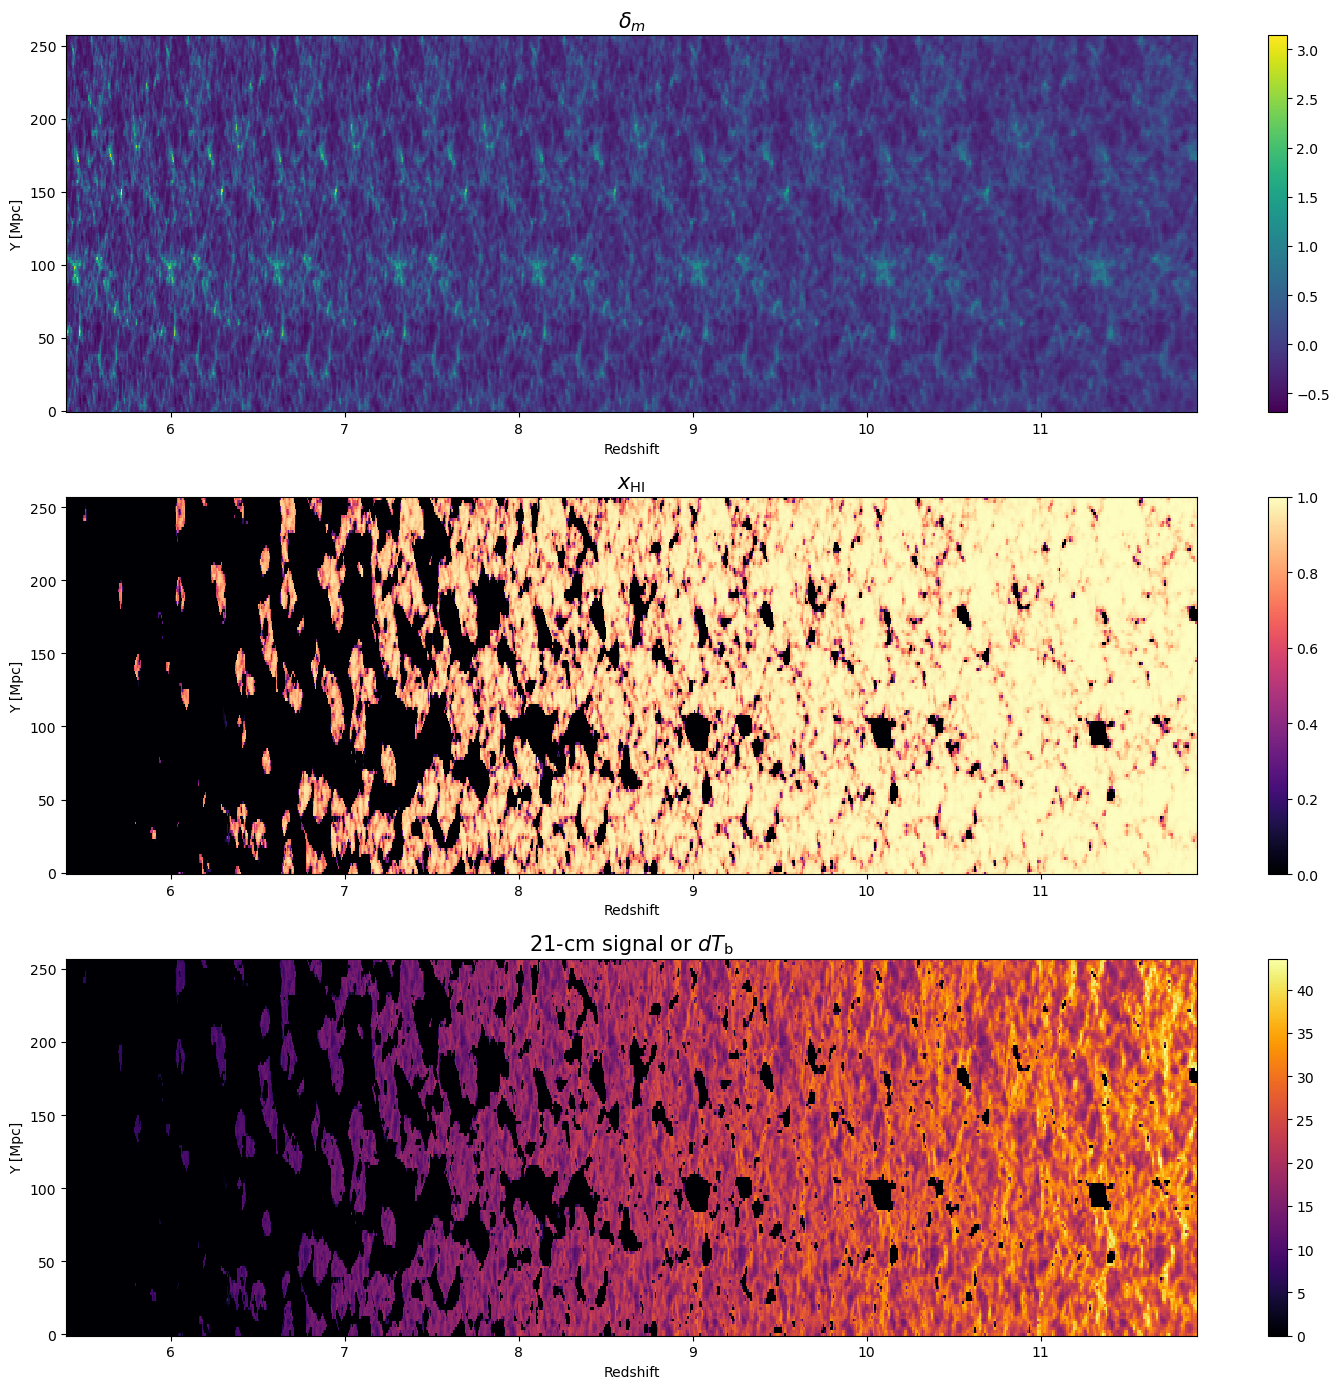

In [14]:
fig, axs = plt.subplots(3,1,figsize=(15,14))

axs[0].set_title('$\delta_m$', fontsize=15)
xx = lc_dens_zs.copy()
yy = np.linspace(0, ic.user_params.BOX_LEN, lc_dens_phy.shape[1])
c0 = axs[0].pcolor(xx, yy, lc_dens_phy[10])
fig.colorbar(c0, ax=axs[0], orientation='vertical')

axs[1].set_title(r'$x_\mathrm{HI}$', fontsize=15)
xx = lc_xHI_zs.copy()
yy = np.linspace(0, ic.user_params.BOX_LEN, lc_xHI_phy.shape[1])
c1 = axs[1].pcolor(xx, yy, lc_xHI_phy[10], cmap='magma')
fig.colorbar(c1, ax=axs[1], orientation='vertical')

axs[2].set_title(r'21-cm signal or $dT_\mathrm{b}$', fontsize=15)
xx = lc_21cm_zs.copy()
yy = np.linspace(0, ic.user_params.BOX_LEN, lc_21cm_phy.shape[1])
c2 = axs[2].pcolor(xx, yy, lc_21cm_phy[10], cmap='inferno')
fig.colorbar(c2, ax=axs[2], orientation='vertical')

for ax in axs:
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Y [Mpc]')

plt.tight_layout()
plt.show()

### Light-cones in observational units

The simulations are performed in comoving units (Mpc) at different redshifts, which is the units for the simulated light-cones above. But observations will record degrees or arcminutes for field of view and frequency or wavelength for redshifts. The simulation and observational units are not linear conversions. Therefore the simulated light-cone has to be re-gridded in the observational units.

In [15]:
output_dnu = 0.1 #MHz
output_dtheta = 1 #arcmin

lc_21cm_obs, lc_21cm_nu = t2c.physical_lightcone_to_observational(
                    lc_21cm_phy, 
                    lc_21cm_zs.min(), 
                    output_dnu, 
                    output_dtheta, 
                    input_box_size_mpc=ic.user_params.BOX_LEN, 
                    verbose=True, 
                    order=2
                    )

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:01<00:00, 624.42it/s]


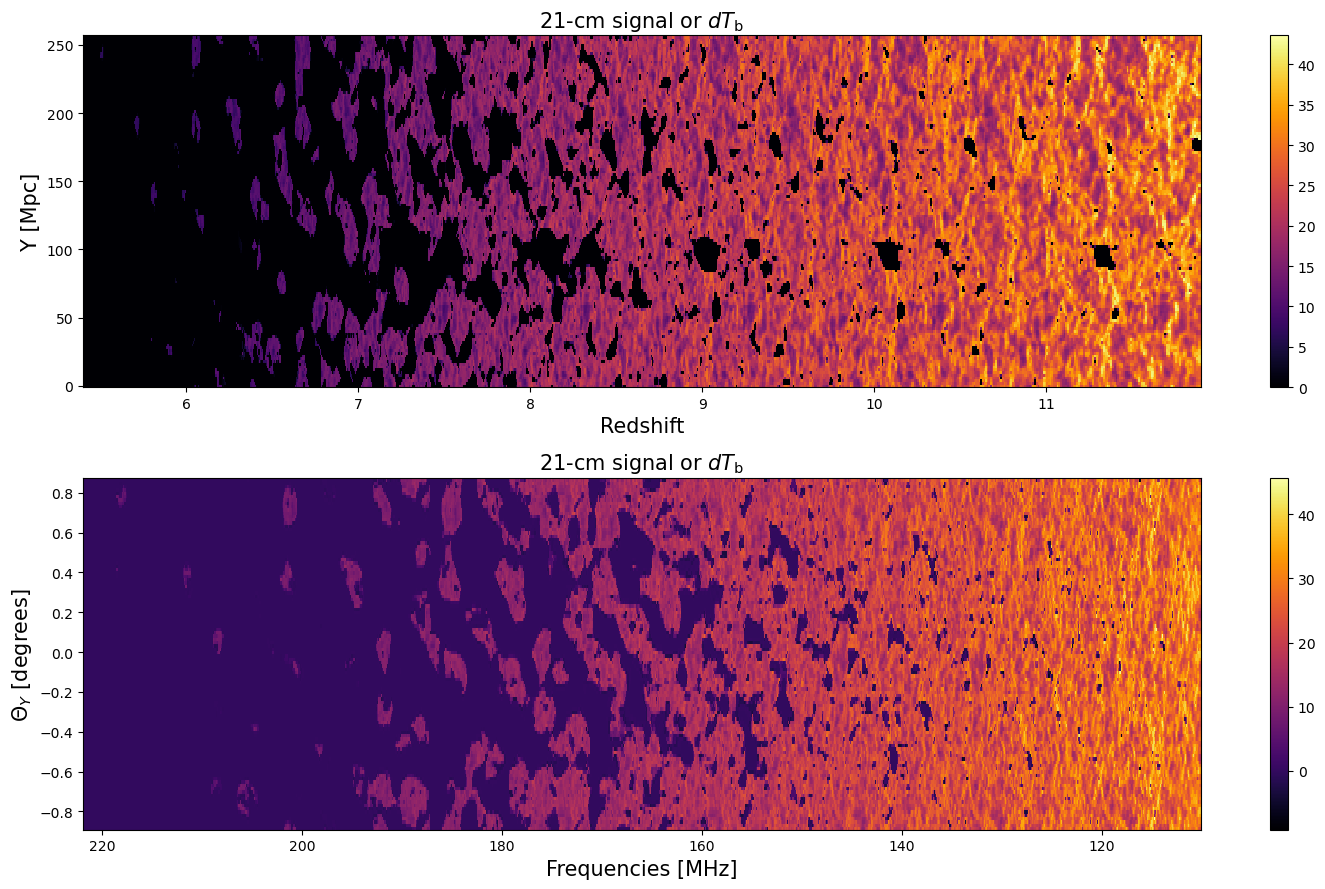

In [16]:
fig, axs = plt.subplots(2,1,figsize=(15,9))

axs[0].set_title(r'21-cm signal or $dT_\mathrm{b}$', fontsize=15)
xx = lc_21cm_zs.copy()
yy = np.linspace(0, ic.user_params.BOX_LEN, lc_21cm_phy.shape[1])
c0 = axs[0].pcolor(xx, yy, lc_21cm_phy[10], cmap='inferno')
fig.colorbar(c0, ax=axs[0], orientation='vertical')
axs[0].set_xlabel('Redshift', fontsize=15)
axs[0].set_ylabel('Y [Mpc]', fontsize=15)

axs[1].set_title(r'21-cm signal or $dT_\mathrm{b}$', fontsize=15)
xx = lc_21cm_nu.copy()
yy = output_dtheta*(np.arange(lc_21cm_obs.shape[1])-lc_21cm_obs.shape[1]/2)/60 #degrees
c1 = axs[1].pcolor(xx, yy, lc_21cm_obs[10], cmap='inferno')
fig.colorbar(c1, ax=axs[1], orientation='vertical')
axs[1].invert_xaxis()
axs[1].set_xlabel('Frequencies [MHz]', fontsize=15)
axs[1].set_ylabel(r'$\Theta_Y$ [degrees]', fontsize=15)

plt.tight_layout()
plt.show()

## Simulate radio interferrometric observation
We will assume the antenna distribution of the SKA-Low.

### Observation Setup
The radio interferrometric telescope observes the sky in Fourier space, which is known as $uv$-space. The rotation of the earth helps observe different parts of the observed field. This rotation manifests in tracks in the $uv$ space that correspond to number of times a certain part is observed.

In [17]:
total_int_time = 6.0 #hours, per day observations
int_time  = 10       #seconds, intergration time
depth_mhz = 10       #MHz, bandwidth
obs_time  = 1000     #hours, total observation time

### $uv$ tracks

In [18]:
uv_maps = {}

for zi in redshifts:
    print(f'z={zi:.1f}')
    uvi, N_ant = t2c.get_uv_map(
                            HII_DIM, 
                            zi, 
                            filename = None, 
                            total_int_time = total_int_time,
                            int_time = int_time,
                            boxsize  = BOX_LEN, 
                           )
    uv_maps[zi] = uvi
    print('...done')

z=7.0
Making uv map from daily observations.


100%|████████████████████████████████████████████████████████████████████████████████████████████| 2159/2159 [00:47<00:00, 45.15it/s]


...done
...done
z=9.0
Making uv map from daily observations.


100%|████████████████████████████████████████████████████████████████████████████████████████████| 2159/2159 [00:51<00:00, 41.62it/s]


...done
...done
z=11.0
Making uv map from daily observations.


100%|████████████████████████████████████████████████████████████████████████████████████████████| 2159/2159 [00:56<00:00, 38.24it/s]

...done
...done


The `uv_map` produced by tools21cm contains the number of times the telescope observes a certain pixel in physical space. As different redshifts correspond to different resolution in the physical space, the tracks will look different.

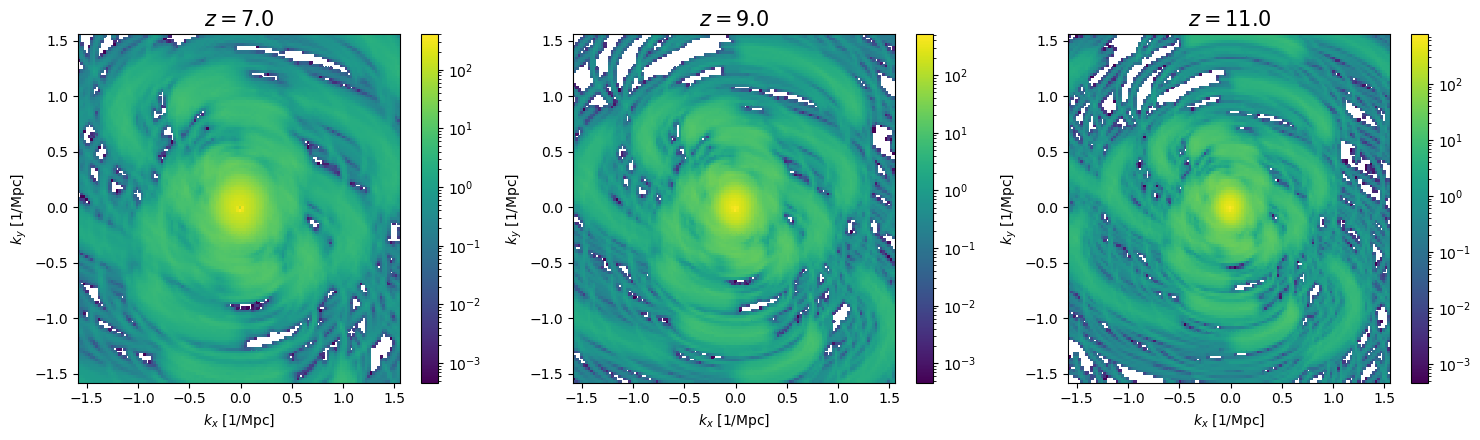

In [19]:
fig, axs = plt.subplots(1,3,figsize=(15,4.5))
x, y = np.indices(uv_maps[7.0].shape, dtype='int32')
kx = 2.*np.pi * (x-HII_DIM/2)/BOX_LEN
ky = 2.*np.pi * (y-HII_DIM/2)/BOX_LEN
for ii,zi in enumerate(redshifts):
    axs[ii].set_title(f'$z={zi:.1f}$', fontsize=15)
    ci = axs[ii].pcolor(kx, ky, np.fft.fftshift(uv_maps[zi]), norm=LogNorm(), cmap='viridis')
    fig.colorbar(ci, ax=axs[ii], orientation='vertical')
for ax in axs:
    ax.set_xlabel('$k_x$ [1/Mpc]')
    ax.set_ylabel('$k_y$ [1/Mpc]')
plt.tight_layout()
plt.show()

### Instrumental Noise

In [20]:
noise_coevals = {}

for zi in redshifts:
    print(f'z={zi:.1f}')
    noi = t2c.noise_cube_coeval(
                            HII_DIM, 
                            zi, 
                            depth_mhz= None,
                            filename = None, 
                            obs_time = obs_time,
                            total_int_time = total_int_time,
                            int_time = int_time,
                            boxsize  = BOX_LEN, 
                            uv_map   = uv_maps[zi],
                           )
    noise_coevals[zi] = noi
    print('...done')

z=7.0
Creating the noise cube...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1017.56it/s]


...done
z=9.0
Creating the noise cube...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1021.12it/s]


...done
z=11.0
Creating the noise cube...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1021.25it/s]

...done


In [21]:
dT_21cm = {}
dT_21cm_true = {}

for zi in redshifts:
    dT_21cm_true[zi] = t2c.subtract_mean_signal(coevals[zi].brightness_temp,los_axis=2)
    dT_21cm[zi] = noise_coevals[zi]+dT_21cm_true[zi]

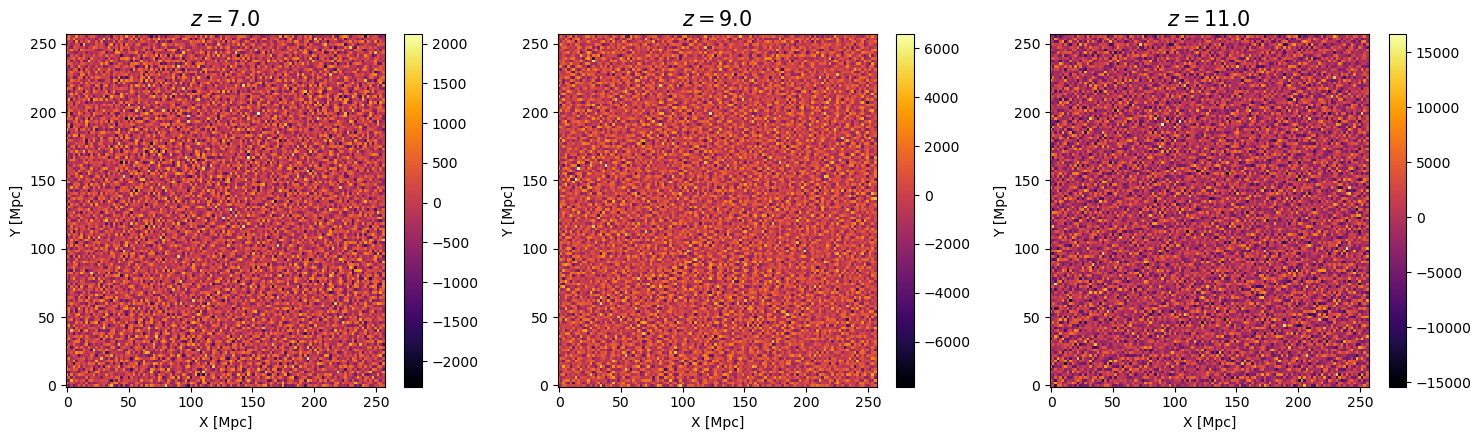

In [22]:
fig, axs = plt.subplots(1,3,figsize=(15,4.5))

xx = np.linspace(0,BOX_LEN,HII_DIM)
yy = np.linspace(0,BOX_LEN,HII_DIM)
for ii,zi in enumerate(redshifts):
    axs[ii].set_title(f'$z={zi:.1f}$', fontsize=15)
    ci = axs[ii].pcolor(xx, yy, dT_21cm[zi][:,:,10], cmap='inferno')
    fig.colorbar(ci, ax=axs[ii], orientation='vertical')
for ax in axs:
    ax.set_xlabel('X [Mpc]')
    ax.set_ylabel('Y [Mpc]')
plt.tight_layout()
plt.show()

The system noise will be very high for the achieveing the same resolution as the simulations (see above). This is due to shallow filling of long baselines (see the white regions in the `uv_map` plot). Therefore we smooth the images down by putting a limit on the maximum baseline of SKA-Low. 

100%|████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 4831.28it/s]


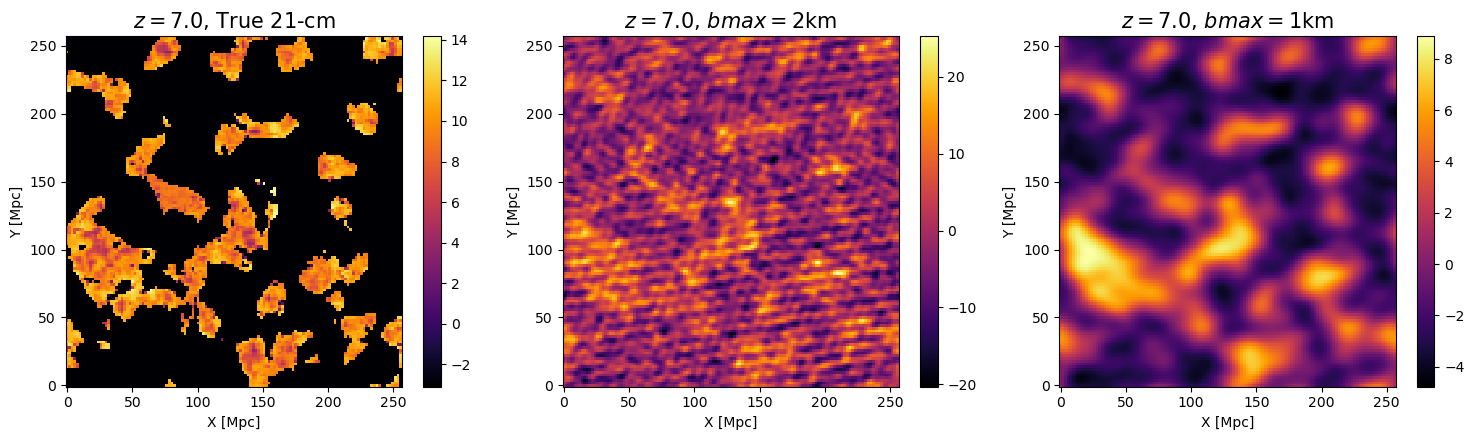

In [23]:
fig, axs = plt.subplots(1,3,figsize=(15,4.5))

xx = np.linspace(0,BOX_LEN,HII_DIM)
yy = np.linspace(0,BOX_LEN,HII_DIM)
max_baselines = [2,1]
red = 7.0
for ii,bmax in enumerate(max_baselines):
    ii += 1
    axs[ii].set_title(f'$z={red:.1f}$, $bmax={bmax:.0f}$km', fontsize=15)
    dT_smt = t2c.smooth_coeval(
                dT_21cm[red], 
                red, 
                box_size_mpc = BOX_LEN, 
                max_baseline = bmax,  
                nu_axis = 2, 
                )
    ci = axs[ii].pcolor(xx, yy, dT_smt[:,:,10], cmap='inferno')
    fig.colorbar(ci, ax=axs[ii], orientation='vertical')
ii = 0
axs[ii].set_title(f'$z={red:.1f}$, True 21-cm', fontsize=15)
ci = axs[ii].pcolor(xx, yy, dT_21cm_true[red][:,:,10], cmap='inferno')
fig.colorbar(ci, ax=axs[ii], orientation='vertical')
for ax in axs:
    ax.set_xlabel('X [Mpc]')
    ax.set_ylabel('Y [Mpc]')
plt.tight_layout()
plt.show()


### System Noise added to the 21-cm Light-cone 

For the light-cone, every slice along the line of sight axis is a different redshift. Therefore $uv$ track maps have to be created for every light-cone redshift, which is a time consuming step below.

In [24]:
lc_noise = t2c.noise_lightcone(
                HII_DIM, 
                lc_21cm_zs, 
                obs_time=obs_time,  
                boxsize=BOX_LEN, 
                save_uvmap=f'uv_{BOX_LEN}Mpc_{HII_DIM}_zmin{lc_21cm_zs.min():.0f}_zmax{lc_21cm_zs.max():.0f}.pkl', 
                total_int_time=total_int_time, 
                int_time=int_time,  
                n_jobs=4, 
                checkpoint=16,
                )

All or some uv maps is read from the given file. Be sure that they were run with the same parameter values as provided now.
Creating the uv maps.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   0 out of   0 | elapsed:    0.0s finished


...done
Creating noise.

z = 5.400 | 0.10 % completed

z = 5.404 | 0.21 % completed

z = 5.408 | 0.31 % completed

z = 5.412 | 0.42 % completed

z = 5.416 | 0.52 % completed

z = 5.420 | 0.62 % completed

z = 5.424 | 0.73 % completed

z = 5.428 | 0.83 % completed

z = 5.432 | 0.94 % completed

z = 5.436 | 1.04 % completed

z = 5.440 | 1.14 % completed

z = 5.444 | 1.25 % completed

z = 5.448 | 1.35 % completed

z = 5.452 | 1.46 % completed

z = 5.456 | 1.56 % completed

z = 5.460 | 1.66 % completed

z = 5.464 | 1.77 % completed

z = 5.468 | 1.87 % completed

z = 5.472 | 1.98 % completed

z = 5.476 | 2.08 % completed

z = 5.480 | 2.18 % completed

z = 5.484 | 2.29 % completed

z = 5.488 | 2.39 % completed

z = 5.492 | 2.49 % completed

z = 5.496 | 2.60 % completed

z = 5.500 | 2.70 % completed

z = 5.504 | 2.81 % completed

z = 5.508 | 2.91 % completed

z = 5.512 | 3.01 % completed

z = 5.516 | 3.12 % completed

z = 5.520 | 3.22 % completed

z = 5.524 | 3.33 % completed

z = 5.528 | 3.4


z = 7.466 | 44.18 % completed

z = 7.472 | 44.28 % completed

z = 7.478 | 44.39 % completed

z = 7.484 | 44.49 % completed

z = 7.490 | 44.59 % completed

z = 7.496 | 44.70 % completed

z = 7.502 | 44.80 % completed

z = 7.508 | 44.91 % completed

z = 7.514 | 45.01 % completed

z = 7.520 | 45.11 % completed

z = 7.526 | 45.22 % completed

z = 7.532 | 45.32 % completed

z = 7.538 | 45.43 % completed

z = 7.544 | 45.53 % completed

z = 7.550 | 45.63 % completed

z = 7.556 | 45.74 % completed

z = 7.562 | 45.84 % completed

z = 7.569 | 45.95 % completed

z = 7.575 | 46.05 % completed

z = 7.581 | 46.15 % completed

z = 7.587 | 46.26 % completed

z = 7.593 | 46.36 % completed

z = 7.599 | 46.47 % completed

z = 7.605 | 46.57 % completed

z = 7.611 | 46.67 % completed

z = 7.618 | 46.78 % completed

z = 7.624 | 46.88 % completed

z = 7.630 | 46.99 % completed

z = 7.636 | 47.09 % completed

z = 7.642 | 47.19 % completed

z = 7.648 | 47.30 % completed

z = 7.655 | 47.40 % completed

z = 7.6


z = 10.159 | 82.12 % completed

z = 10.168 | 82.22 % completed

z = 10.177 | 82.33 % completed

z = 10.186 | 82.43 % completed

z = 10.195 | 82.54 % completed

z = 10.204 | 82.64 % completed

z = 10.213 | 82.74 % completed

z = 10.222 | 82.85 % completed

z = 10.232 | 82.95 % completed

z = 10.241 | 83.06 % completed

z = 10.250 | 83.16 % completed

z = 10.259 | 83.26 % completed

z = 10.268 | 83.37 % completed

z = 10.277 | 83.47 % completed

z = 10.287 | 83.58 % completed

z = 10.296 | 83.68 % completed

z = 10.305 | 83.78 % completed

z = 10.314 | 83.89 % completed

z = 10.324 | 83.99 % completed

z = 10.333 | 84.10 % completed

z = 10.342 | 84.20 % completed

z = 10.351 | 84.30 % completed

z = 10.361 | 84.41 % completed

z = 10.370 | 84.51 % completed

z = 10.379 | 84.62 % completed

z = 10.389 | 84.72 % completed

z = 10.398 | 84.82 % completed

z = 10.407 | 84.93 % completed

z = 10.417 | 85.03 % completed

z = 10.426 | 85.14 % completed

z = 10.435 | 85.24 % completed

z = 10.

In [25]:
lc_21cm_phy_noisy = lc_21cm_phy+lc_noise

lc_21cm_phy_smt = {}
max_baselines = [2,1]
for bmax in max_baselines:
    print(f'bmax={bmax:.0f}km')
    smt0, zs0 = t2c.smooth_lightcone(
                                lc_21cm_phy_noisy, 
                                lc_21cm_zs, 
                                box_size_mpc=BOX_LEN, 
                                max_baseline=bmax,
                                )
    lc_21cm_phy_smt[bmax] = smt0
    lc_21cm_phy_smt['z'] = zs0
    print('...done')

bmax=2km


100%|████████████████████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 4464.49it/s]


...done
bmax=1km


100%|████████████████████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 4070.75it/s]


...done


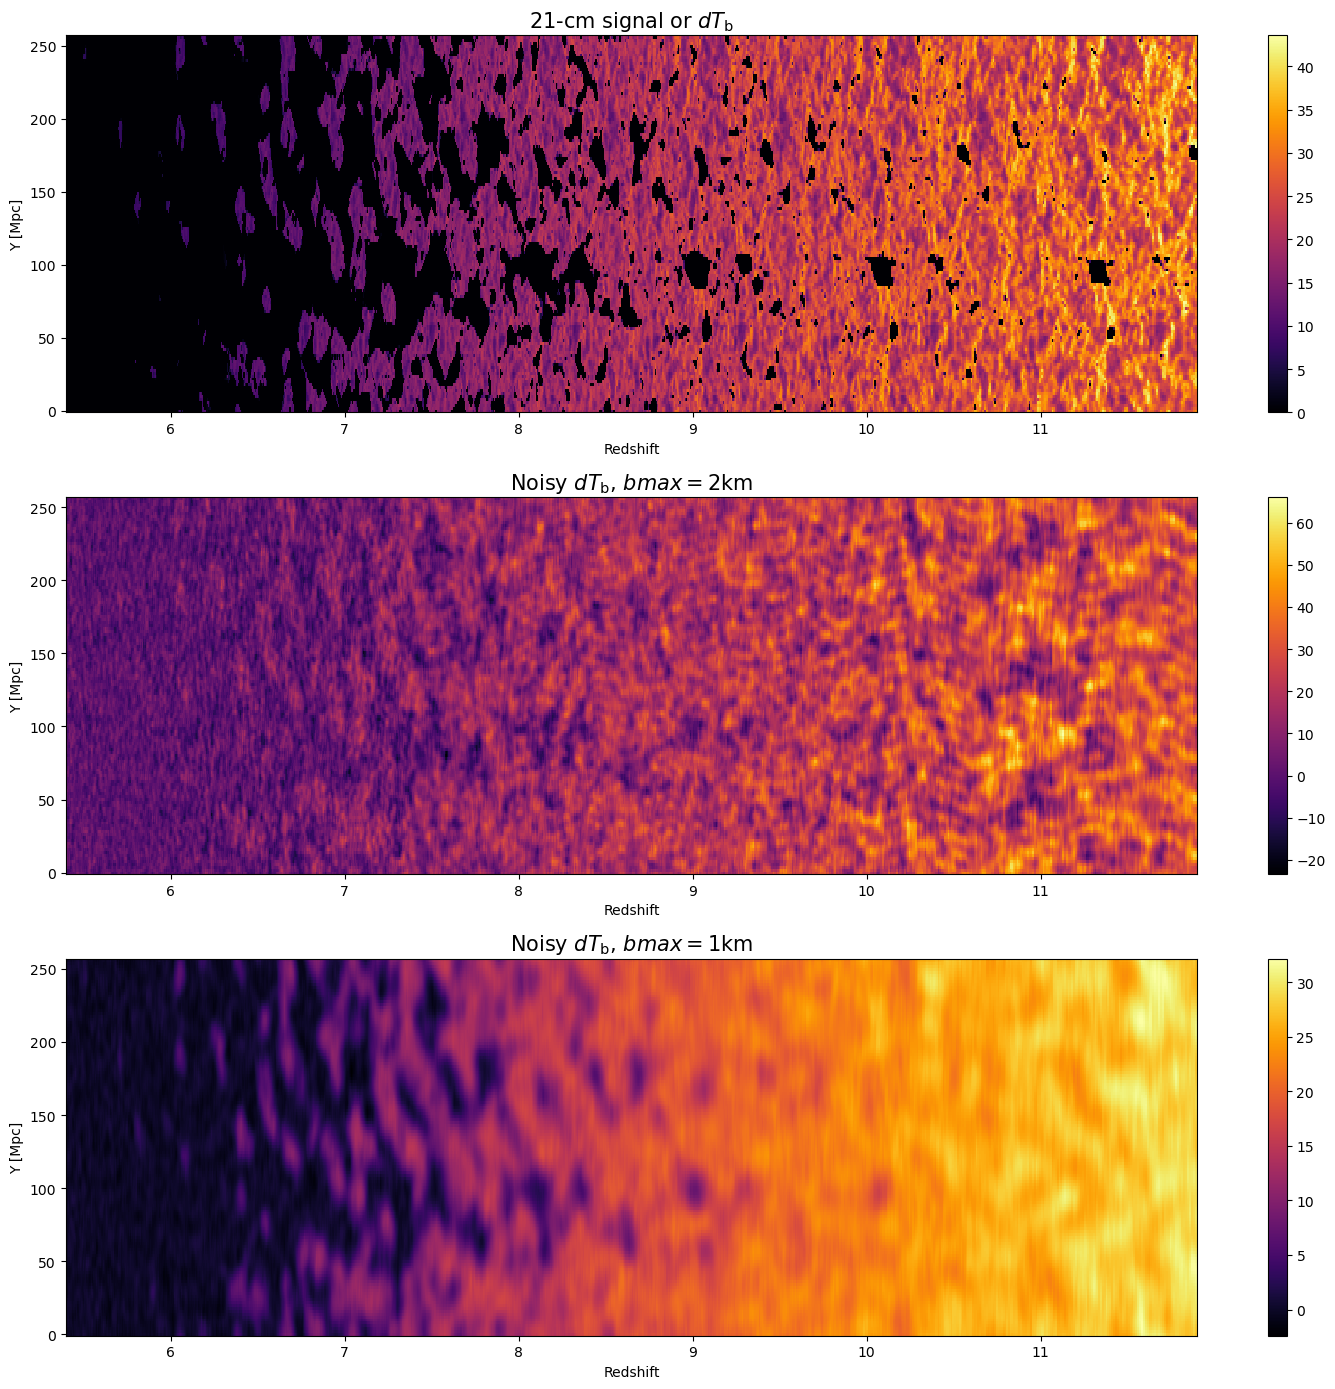

In [26]:
fig, axs = plt.subplots(3,1,figsize=(15,14))

axs[0].set_title(r'21-cm signal or $dT_\mathrm{b}$', fontsize=15)
xx = lc_21cm_zs.copy()
yy = np.linspace(0, ic.user_params.BOX_LEN, lc_21cm_phy.shape[1])
c0 = axs[0].pcolor(xx, yy, lc_21cm_phy[10], cmap='inferno')
fig.colorbar(c0, ax=axs[0], orientation='vertical')

bmax = 2
axs[1].set_title(f'Noisy $dT_\mathrm{{b}}$, $bmax={bmax:.0f}$km', fontsize=15)
xx = lc_21cm_zs.copy()
yy = np.linspace(0, ic.user_params.BOX_LEN, lc_21cm_phy.shape[1])
c1 = axs[1].pcolor(xx, yy, lc_21cm_phy_smt[bmax][10], cmap='inferno')
fig.colorbar(c1, ax=axs[1], orientation='vertical')

bmax = 1
axs[2].set_title(f'Noisy $dT_\mathrm{{b}}$, $bmax={bmax:.0f}$km', fontsize=15)
xx = lc_21cm_zs.copy()
yy = np.linspace(0, ic.user_params.BOX_LEN, lc_21cm_phy.shape[1])
c2 = axs[2].pcolor(xx, yy, lc_21cm_phy_smt[bmax][10], cmap='inferno')
fig.colorbar(c2, ax=axs[2], orientation='vertical')

for ax in axs:
    ax.set_ylabel('Y [Mpc]')
    ax.set_xlabel('Redshift')

plt.tight_layout()
plt.show()

We will transform the noisy light-cones in physical space to observational space.

In [27]:
output_dnu = 0.1 #MHz
output_dtheta = 1 #arcmin

lc_21cm_obs_smt = {}
max_baselines = [2,1]
for bmax in max_baselines:
    print(f'bmax={bmax:.0f}km')
    lc_obs0, lc_nu0 = t2c.physical_lightcone_to_observational(
                        lc_21cm_phy_smt[bmax], 
                        lc_21cm_phy_smt['z'].min(), 
                        output_dnu, 
                        output_dtheta, 
                        input_box_size_mpc=ic.user_params.BOX_LEN, 
                        verbose=True, 
                        order=2
                        )
    lc_21cm_obs_smt[bmax] = lc_obs0
    lc_21cm_obs_smt['nu'] = lc_nu0
    print('...done')

bmax=2km


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:01<00:00, 612.30it/s]


...done
bmax=1km


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:01<00:00, 614.63it/s]

...done


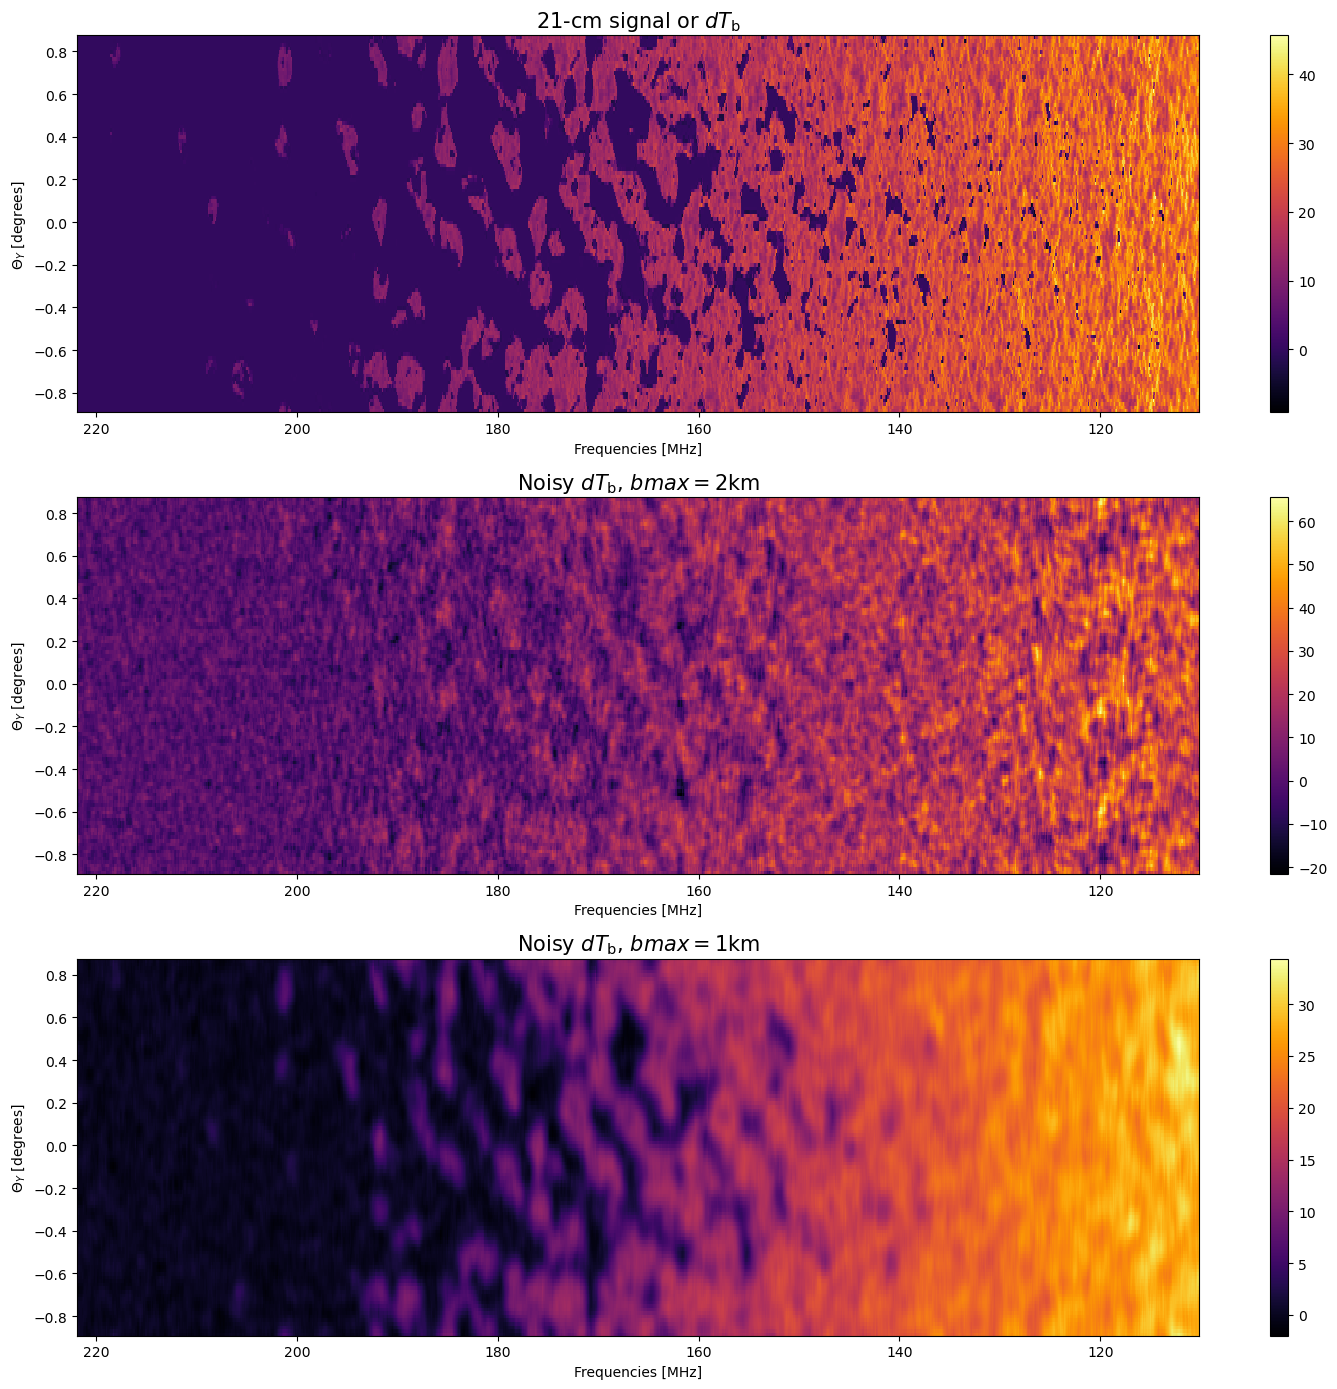

In [28]:
fig, axs = plt.subplots(3,1,figsize=(15,14))

axs[0].set_title(r'21-cm signal or $dT_\mathrm{b}$', fontsize=15)
xx = lc_21cm_nu.copy()
yy = output_dtheta*(np.arange(lc_21cm_obs.shape[1])-lc_21cm_obs.shape[1]/2)/60 #degrees
c0 = axs[0].pcolor(xx, yy, lc_21cm_obs[10], cmap='inferno')
fig.colorbar(c0, ax=axs[0], orientation='vertical')

bmax = 2
axs[1].set_title(f'Noisy $dT_\mathrm{{b}}$, $bmax={bmax:.0f}$km', fontsize=15)
xx = lc_21cm_nu.copy()
yy = output_dtheta*(np.arange(lc_21cm_obs_smt[bmax].shape[1])-lc_21cm_obs_smt[bmax].shape[1]/2)/60 #degrees
c1 = axs[1].pcolor(xx, yy, lc_21cm_obs_smt[bmax][10], cmap='inferno')
fig.colorbar(c1, ax=axs[1], orientation='vertical')

bmax = 1
axs[2].set_title(f'Noisy $dT_\mathrm{{b}}$, $bmax={bmax:.0f}$km', fontsize=15)
xx = lc_21cm_nu.copy()
yy = output_dtheta*(np.arange(lc_21cm_obs_smt[bmax].shape[1])-lc_21cm_obs_smt[bmax].shape[1]/2)/60 #degrees
c2 = axs[2].pcolor(xx, yy, lc_21cm_obs_smt[bmax][10], cmap='inferno')
fig.colorbar(c2, ax=axs[2], orientation='vertical')

for ax in axs:
    ax.invert_xaxis()
    ax.set_ylabel(r'$\Theta_Y$ [degrees]')
    ax.set_xlabel('Frequencies [MHz]')

plt.tight_layout()
plt.show()